Vamos a importar las librerías que vamos a necesitar a lo largo de la practica

In [19]:
%matplotlib inline
import numpy as np
import requests as rq
import json
import urllib2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import normaltest

Nos conectamos al API de 4chan para obtener el json de los dashboards de la web:

In [2]:
r = rq.get('https://a.4cdn.org/boards.json')
boards = json.loads(r.text)
print(json.dumps(boards, indent=3))#  mostramos los boards con un formato más legible

{
   "boards": [
      {
         "max_webm_duration": 120, 
         "meta_description": "&quot;/3/ - 3DCG&quot; is 4chan's board for 3D modeling and imagery.", 
         "cooldowns": {
            "images": 60, 
            "threads": 600, 
            "replies": 60
         }, 
         "title": "3DCG", 
         "is_archived": 1, 
         "max_comment_chars": 2000, 
         "ws_board": 1, 
         "max_filesize": 4194304, 
         "board": "3", 
         "max_webm_filesize": 3145728, 
         "per_page": 15, 
         "bump_limit": 310, 
         "image_limit": 150, 
         "pages": 10
      }, 
      {
         "max_webm_duration": 120, 
         "meta_description": "&quot;/a/ - Anime &amp; Manga&quot; is 4chan's imageboard dedicated to the discussion of Japanese animation and manga.", 
         "cooldowns": {
            "images": 60, 
            "threads": 600, 
            "replies": 60
         }, 
         "title": "Anime & Manga", 
         "spoilers": 1, 
         "

Para hacer la comparativa utilizaremos el primer y ultimo board. Para ello necesitamos conocer el número de boards. 

In [3]:
tam=len(boards["boards"])
print tam

71


Hay que tener en cuenta que en python se empieza a contar en el cero, por lo que el primer boar es el 0 y el ultimo es tam-1

In [4]:
board1=boards["boards"][0]
board2=boards["boards"][tam-1]

creamos una funcion que nos guarde los datos del board en un dataframe. La vamos a utilizar para guardar los dos boards en un mismo dataframe

In [5]:
def add_dataframe(df, board):
    pages = board["pages"] # Obtenemos el número de paginas del board
    for cont_paginas in range(pages): #vamos a recorrer todas las paginas del board
        url_page = 'https://a.4cdn.org/' + board["board"] + '/'+ str(cont_paginas+1) + '.json' #montamos la url del json de la pagina
        p = rq.get(url_page, allow_redirects=False)
        contents = json.loads(p.text)
        for i in contents["threads"]:
            for j in i["posts"]:
                number = int(j["no"])
                name = j["name"]
                boardNumber = board["board"]
                replies = 0
                fsize = 0
                if ("name" in j):
                    name = j["name"]               
                if ("replies" in j):
                    replies = int(j["replies"])
                if ("fsize" in j):
                    fsize = int(j["fsize"])
                df.loc[len(df)] = [boardNumber, name, fsize, replies]#añadimos en la ultima posicion

Aplicamos la función creada a ambos boards para crear el data frame con trodos los datos

In [6]:
datos = pd.DataFrame(columns=["board","name", "fsize","replies"])#creamos el dataframe vacío
add_dataframe(datos,board1)
add_dataframe(datos,board2)
datos.size

6844

In [7]:
datos.head(5)

,board,name,fsize,replies
0,3,Anonymous,3277.0,73.0
1,3,Anonymous,59371.0,0.0
2,3,Anonymous,9395.0,15.0
3,3,Anonymous,0.0,0.0
4,3,Anonymous,0.0,0.0


Eliminamos los datos cuyo fsize o replies es cero

In [8]:
datos=datos[(datos.fsize>0) & (datos.replies>0)]

In [9]:
datos.head(10)

,board,name,fsize,replies
0,3,Anonymous,3277.0,73.0
2,3,Anonymous,9395.0,15.0
8,3,Anonymous,1260576.0,31.0
14,3,Anonymous,33580.0,259.0
20,3,Anonymous,166264.0,75.0
26,3,Anonymous,98745.0,24.0
32,3,Anonymous,18769.0,77.0
38,3,Anonymous,28433.0,6.0
44,3,Anonymous,940757.0,21.0
50,3,Anonymous,130178.0,14.0


obtenemos la media del número de respuestas en cada página, agrupada por boards

In [10]:
datos['replies'].groupby([datos['board']]).mean()

board
3     24.157534
y    115.393333
Name: replies, dtype: float64

Hacemos el contraste de medias con un ttest

In [11]:
from scipy.stats import ttest_ind
datosGrouped = datos['replies'].groupby([datos['board']])
g1, g2 = datosGrouped.groups.values()
ts, p = ttest_ind(g1, g2)
print p
print 'Medias distintas' if p < 0.05 else 'Medias iguales'

6.74783761204e-89
Medias distintas


Con un p-valor tan bajo, rechazamos la hipótesis de igualdad de medias

Ahora vamos a estudiar el tamaño de las imágenes en el primer board.
Generamos gráficos para ver visualmente la distribución que siguen

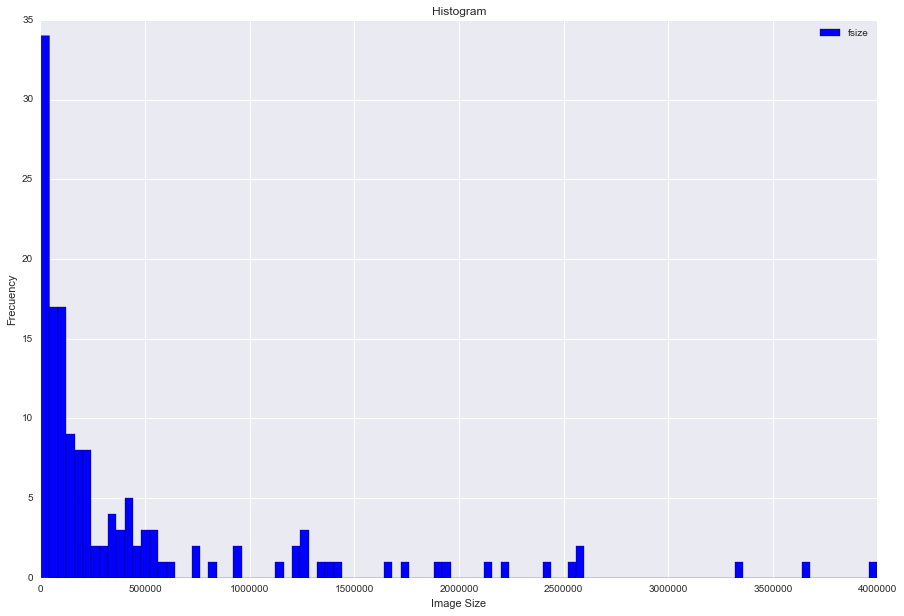

In [12]:
board1_df = datos[datos.board == board1["board"]]
ax = board1_df['fsize'].plot(kind="hist", title ="Histogram",color='blue',figsize=(15,10),legend=True, fontsize=10, bins=100)
plt.ylabel('Frecuency')
plt.xlabel('Image Size')
plt.show()

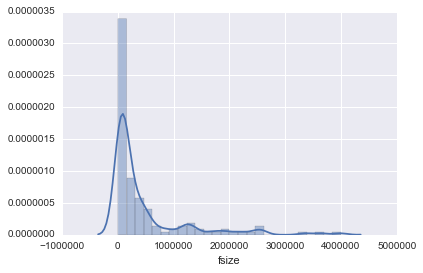

In [26]:
sns.distplot(board1_df["fsize"])

A la vista de los gráficos, observamos que los datos se concentran en los valores más bajos, en torno al cero, y hay algunos datos con valores altos que hacen que la distribución tenga una cola hacia la derecha, por lo que suponemos que no es una distribucion normal
Vamos a hacer un test de normalidad para confirmar lo que se ve gráficamente

In [23]:
z,pvalor = normaltest(board1_df['fsize'])
pvalor

2.8143752539460754e-21

Con un pvalor tan pequeño, tenemos que rechazar la posibilidad de que el tamaño de las imagenes sigan una distribución normal.